In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

In [3]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.advanced_activations import LeakyReLU, PReLU

Using TensorFlow backend.


In [4]:
# REQUIRED FUNCTION

def shift(df, obj, step=1):
    '''
    '''
    df = pd.concat([df.shift(step), df[obj]], axis=1)
    df = df.dropna()
#     df = df.sample(df.shape[0])
    df = df.values
#     time = df[:, 0]
    X, y = df[:, :-1], df[:, -1]
    return X, y

def scale(train, valid, feature_range=(0, 1)):
    '''
    '''
    scaler = MinMaxScaler(feature_range=feature_range)
    scaler.fit(train)
    
    train_scaled = scaler.transform(train)
    valid_scaled = scaler.transform(valid)
    
    return scaler, train_scaled, valid_scaled

def inverse(scaler, fea, y_pred):
    '''
    '''
    array    = np.c_[fea, y_pred]
    inverted = scaler.inverse_transform(array)
    return inverted[:, -1]

def to_DF(col_name, *args):
    '''
    '''
    assert len(args) != 0, "There are no input data."
    
    df_list = list()
    for arg in args:
        df = pd.DataFrame(data=arg, columns = col_name)
        df_list.append(df)

    return df_list

def MASE(pred, target, orig):
    '''
    '''
    n     = len(target)
    MAE   = np.mean(sum(np.abs(target - pred)))
    MAE_n = np.mean(sum(np.abs(target - orig)))
    e     = MAE / ((n + 1) * MAE_n / n)
    return e

def MAPE(pred, orig):
    '''
    '''
    e = np.mean(np.abs((orig - pred)/orig))
    return e

In [2]:
w1 = pd.read_csv('w1-cali.csv')
w1['date'] = pd.to_datetime(w1['date'])
w = w1.drop(['date'], axis=1)
train1, test1 = w[:500], w[500:]

In [4]:
des = w1.describe()
des.to_csv('w1-describe.csv', index=False)

## WHFT

In [154]:
scaler, train, test = scale(train1, test1)
cols = w.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]

In [155]:
vf_whft = test.values[-1].reshape((1, -1))
vf_whft

array([[-0.28504901,  0.12128599,  1.13748432,  0.39114137,  0.7093788 ,
         0.879046  ]])

In [156]:
X_tr1, y_tr1 = shift(train, 'whft', step=1)
X_te1, y_te1 = shift(test, 'whft', step=1)
print(X_tr1.shape, y_tr1.shape, X_te1.shape, y_te1.shape)

(499, 6) (499,) (152, 6) (152,)


In [90]:
whft = Sequential()
whft.add(Dense(7, input_shape=(6, ), activation='linear'))
whft.add(LeakyReLU(alpha=0.001))
whft.add(Dense(1))
whft.compile(loss='mse', optimizer='adam')

In [91]:
epochs=50

h1 = whft.fit(X_tr1, y_tr1, 
             epochs=epochs,
             batch_size=6)

Epoch 1/50
499/499 [==============================] - 1s 3ms/step - loss: 0.3293
Epoch 2/50
499/499 [==============================] - 0s 373us/step - loss: 0.0677
Epoch 3/50
499/499 [==============================] - 0s 407us/step - loss: 0.0336
Epoch 4/50
499/499 [==============================] - 0s 433us/step - loss: 0.0239
Epoch 5/50
499/499 [==============================] - 0s 409us/step - loss: 0.0188
Epoch 6/50
499/499 [==============================] - 0s 381us/step - loss: 0.0158
Epoch 7/50
499/499 [==============================] - 0s 401us/step - loss: 0.0139
Epoch 8/50
499/499 [==============================] - 0s 379us/step - loss: 0.0127
Epoch 9/50
499/499 [==============================] - 0s 443us/step - loss: 0.0116
Epoch 10/50
499/499 [==============================] - 0s 375us/step - loss: 0.0109
Epoch 11/50
499/499 [==============================] - 0s 393us/step - loss: 0.0104
Epoch 12/50
499/499 [==============================] - ETA: 0s - loss: 0.008 - 0s 395us

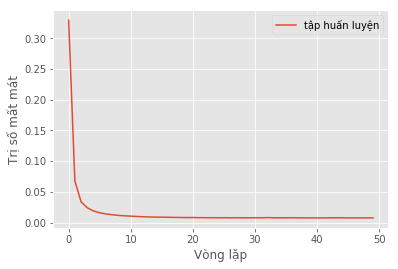

In [208]:
plt.plot(h1.history['loss'], label="tập huấn luyện")
# plt.plot(h1.history['val_loss'], label='tập kiểm thử')
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [209]:
w1_whft_loss = pd.DataFrame({'epochs': range(1,epochs+1),
                            'loss': h1.history['loss']})
w1_whft_loss.to_csv('w1-whft-loss.dat', index=False)

In [93]:
# whft = load_model('save-model-while-train.hdf5')

y_t = whft.predict(X_tr1)
y_pred = whft.predict(X_te1)

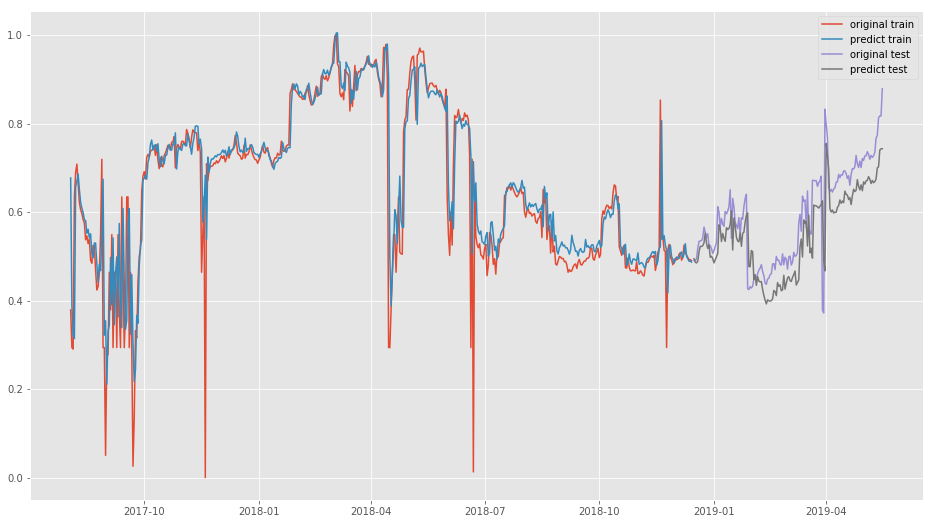

In [98]:
plt.figure(figsize=(16, 9))
plt.plot(w1['date'][1:500], y_tr1,  label='original train')
plt.plot(w1['date'][1:500], y_t,    label='predict train')
plt.plot(w1['date'][501:], y_te1,  label='original test')
plt.plot(w1['date'][501:], y_pred, label='predict test')
plt.legend()
plt.show()

In [99]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_pred, y_te1), MAPE(y_pred, y_te1)))

MSE: 0.0047 | MAPE: 0.1987


In [101]:
# whft.save('whft-loss-0.0047.hdf5')

In [157]:
whft = load_model('whft-loss-0.0047.hdf5')

y_t = whft.predict(X_tr1)
y_pred = whft.predict(X_te1)

In [158]:
whft.layers[2].get_weights()

[array([[ 0.64574546],
        [ 0.16154219],
        [-0.1253145 ],
        [ 1.2631979 ],
        [ 0.6928494 ],
        [ 0.2573959 ],
        [-0.63785404]], dtype=float32), array([0.01623701], dtype=float32)]

In [159]:
y_hat = inverse(scaler, X_te1[:, :-1], y_pred)
y_train_hat = inverse(scaler, X_tr1[:, :-1], y_t)

In [160]:
predict_train_set = pd.DataFrame({'date': w1['date'][1:500].values,
                                  'orig': train1['whft'][1:500].values,
                                  'pred': y_train_hat})

predict_test_set = pd.DataFrame({'date': w1['date'][501:].values,
                                 'orig': test1['whft'][:-1].values,
                                 'pred': y_hat})

predict_train_set.to_csv('whft_train.dat', index=False)
predict_test_set.to_csv('whft_test.dat', index=False)

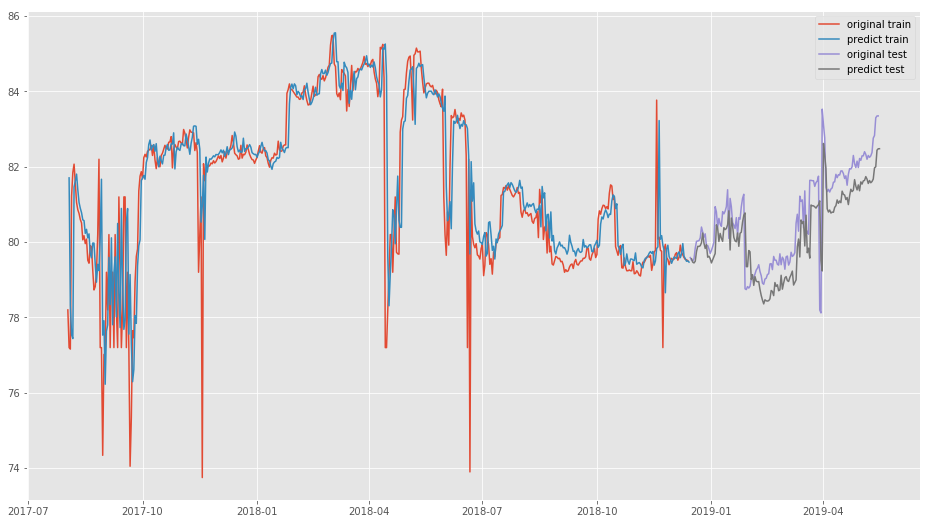

In [161]:
plt.figure(figsize=(16, 9))
plt.plot(w1['date'][:499], train1['whft'][1:500], label='original train')
plt.plot(w1['date'][1:500], y_train_hat, label='predict train')
plt.plot(w1['date'][500:-1], test1['whft'][:-1], label='original test')
plt.plot(w1['date'][501:], y_hat, label='predict test')
plt.legend()
plt.show()

In [106]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(test1['whft'][1:], yhat), MAPE(test1['whft'][1:], yhat)))

MSE: 0.6541 | MAPE: 0.0079


In [316]:
np.sqrt(0.6541)

0.80876448982383

## WHFP

In [162]:
train2 = pd.concat([train1.drop(['whfp'], axis=1), train1['whfp']], axis=1)
test2 = pd.concat([test1.drop(['whfp'], axis=1), test1['whfp']], axis=1)

In [163]:
scaler, train, test = scale(train2, test2)
cols = train2.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(500, 6) (153, 6)


In [164]:
vf_whfp = test.values[-1].reshape((1, -1))
vf_whfp

array([[-0.28504901,  0.12128599,  1.13748432,  0.39114137,  0.879046  ,
         0.7093788 ]])

In [165]:
X_tr2, y_tr2 = shift(train, 'whfp', step=1)
X_te2, y_te2 = shift(test, 'whfp', step=1)
print(X_tr2.shape, y_tr2.shape, X_te2.shape, y_te2.shape)

(499, 6) (499,) (152, 6) (152,)


In [193]:
m2 = Sequential()
m2.add(Dense(7, input_shape=(6, ), activation='linear'))
m2.add(LeakyReLU(alpha=0.001))
m2.add(Dense(1))
m2.compile(loss='mse', optimizer='adam')

In [194]:
epochs=50

h2 = m2.fit(X_tr2, y_tr2, 
          epochs=epochs,
          batch_size=8)

Epoch 1/50
499/499 [==============================] - 2s 3ms/step - loss: 0.1481
Epoch 2/50
499/499 [==============================] - 0s 354us/step - loss: 0.0231
Epoch 3/50
499/499 [==============================] - 0s 363us/step - loss: 0.0171
Epoch 4/50
499/499 [==============================] - 0s 360us/step - loss: 0.0161
Epoch 5/50
499/499 [==============================] - 0s 385us/step - loss: 0.0152
Epoch 6/50
499/499 [==============================] - 0s 385us/step - loss: 0.0144
Epoch 7/50
499/499 [==============================] - 0s 367us/step - loss: 0.0136
Epoch 8/50
499/499 [==============================] - ETA: 0s - loss: 0.012 - 0s 389us/step - loss: 0.0128
Epoch 9/50
499/499 [==============================] - 0s 371us/step - loss: 0.0121
Epoch 10/50
499/499 [==============================] - 0s 389us/step - loss: 0.0114 0s - loss: 0.01
Epoch 11/50
499/499 [==============================] - 0s 363us/step - loss: 0.0108
Epoch 12/50
499/499 [==========================

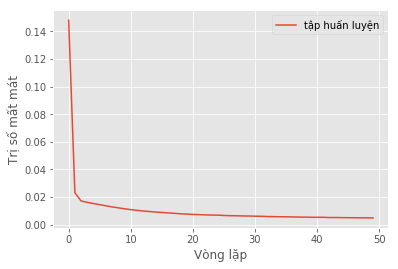

In [195]:
plt.plot(h2.history['loss'], label="tập huấn luyện")
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [207]:
loss = pd.DataFrame({'epochs': range(1,epochs+1),
                     'loss': h2.history['loss']})
loss.to_csv('w1-whfp-loss.dat', index=False)

In [196]:
y_t = m2.predict(X_tr2)
y_pred = m2.predict(X_te2)

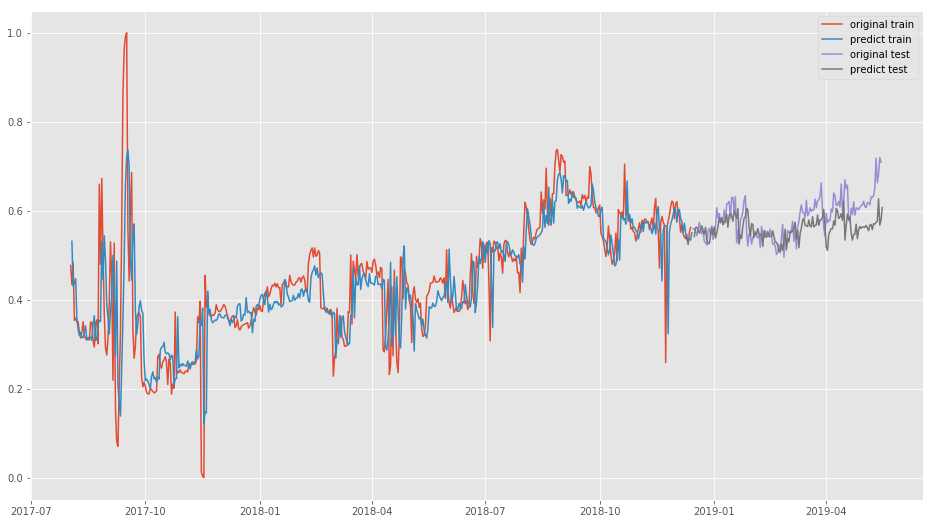

In [197]:
plt.figure(figsize=(16, 9))
plt.plot(w1['date'][:499], y_tr2, label='original train')
plt.plot(w1['date'][1:500], y_t,   label='predict train')
plt.plot(w1['date'][500:-1], y_te2,  label='original test')
plt.plot(w1['date'][501:], y_pred, label='predict test')
plt.legend()
plt.show()

In [198]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_pred, y_te2), MAPE(y_pred, y_te2)))

MSE: 0.0018 | MAPE: 0.0715


In [204]:
m2.save('whfp-loss-0.0018.hdf5')

In [210]:
# whfp = load_model('whfp-loss-0.0042.hdf5')
whfp = m2

y_t = whfp.predict(X_tr2)
y_pred = whfp.predict(X_te2)

In [212]:
y_hat = inverse(scaler, X_te2[:, :-1], y_pred)
y_train_hat = inverse(scaler, X_tr2[:, :-1], y_t)

In [213]:
predict_train_set = pd.DataFrame({'date': w1['date'][1:500].values,
                                  'orig': train2['whfp'][1:500].values,
                                  'pred': y_train_hat})

predict_test_set = pd.DataFrame({'date': w1['date'][501:].values,
                                 'orig': test2['whfp'][:-1].values,
                                 'pred': y_hat})

predict_train_set.to_csv('whfp_train.dat', index=False)
predict_test_set.to_csv('whfp_test.dat', index=False)

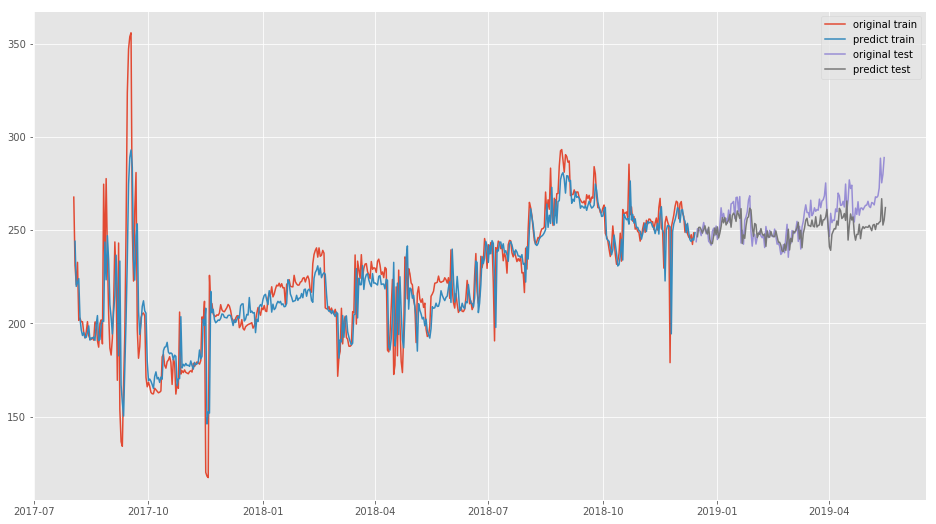

In [215]:
plt.figure(figsize=(16, 9))
plt.plot(w1['date'][:499], train2['whfp'][:499], label='original train')
plt.plot(w1['date'][1:500], y_train_hat, label='predict train')
plt.plot(w1['date'][500:-1], test2['whfp'][:-1], label='original test')
plt.plot(w1['date'][501:], y_hat, label='predict test')
plt.legend()
plt.show()

In [216]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(test2['whfp'][1:], y_hat), MAPE(test2['whfp'][1:], y_hat)))

MSE: 102.0222 | MAPE: 0.0308


In [317]:
np.sqrt(102.0222)

10.100603942339289

## WATER RATE

In [217]:
train3 = pd.concat([train1.drop(['q_water'], axis=1), train1['q_water']], axis=1)
test3 = pd.concat([test1.drop(['q_water'], axis=1), test1['q_water']], axis=1)

In [218]:
scaler, train, test = scale(train3, test3)
cols = train3.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(500, 6) (153, 6)


In [219]:
vf_water = test.values[-1].reshape((1, -1))
vf_water

array([[-0.28504901,  0.12128599,  0.39114137,  0.7093788 ,  0.879046  ,
         1.13748432]])

In [220]:
X_tr3, y_tr3 = shift(train, 'q_water', step=1)
X_te3, y_te3 = shift(test, 'q_water', step=1)
print(X_tr3.shape, y_tr3.shape, X_te3.shape, y_te3.shape)

(499, 6) (499,) (152, 6) (152,)


In [225]:
m3 = Sequential()
m3.add(Dense(7, input_shape=(6, ), activation='linear'))
m3.add(LeakyReLU(alpha=0.001))
m3.add(Dense(1))
m3.compile(loss='mse', optimizer='adam')

In [226]:
epochs=40

h3 = m3.fit(X_tr3, y_tr3, 
          epochs=40,
          batch_size=6)

Epoch 1/40
499/499 [==============================] - 2s 4ms/step - loss: 0.9499
Epoch 2/40
499/499 [==============================] - 0s 461us/step - loss: 0.1764
Epoch 3/40
499/499 [==============================] - 0s 467us/step - loss: 0.0684
Epoch 4/40
499/499 [==============================] - 0s 517us/step - loss: 0.0561
Epoch 5/40
499/499 [==============================] - 0s 519us/step - loss: 0.0464
Epoch 6/40
499/499 [==============================] - 0s 479us/step - loss: 0.0385
Epoch 7/40
499/499 [==============================] - 0s 533us/step - loss: 0.0328
Epoch 8/40
499/499 [==============================] - 0s 521us/step - loss: 0.0283
Epoch 9/40
499/499 [==============================] - 0s 529us/step - loss: 0.0250
Epoch 10/40
499/499 [==============================] - 0s 521us/step - loss: 0.0225
Epoch 11/40
499/499 [==============================] - 0s 517us/step - loss: 0.0206
Epoch 12/40
499/499 [==============================] - 0s 575us/step - loss: 0.0191
Epo

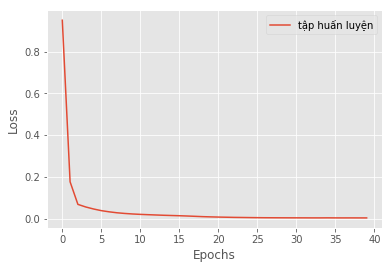

In [227]:
plt.plot(h3.history['loss'], label="tập huấn luyện")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [228]:
loss = pd.DataFrame({'epochs': range(1, epochs+1),
                     'loss': h3.history['loss']})
loss.to_csv('w1-water-loss.dat', index=False)

In [248]:
y_t = m3.predict(X_tr3)
y_pred = m3.predict(X_te3)

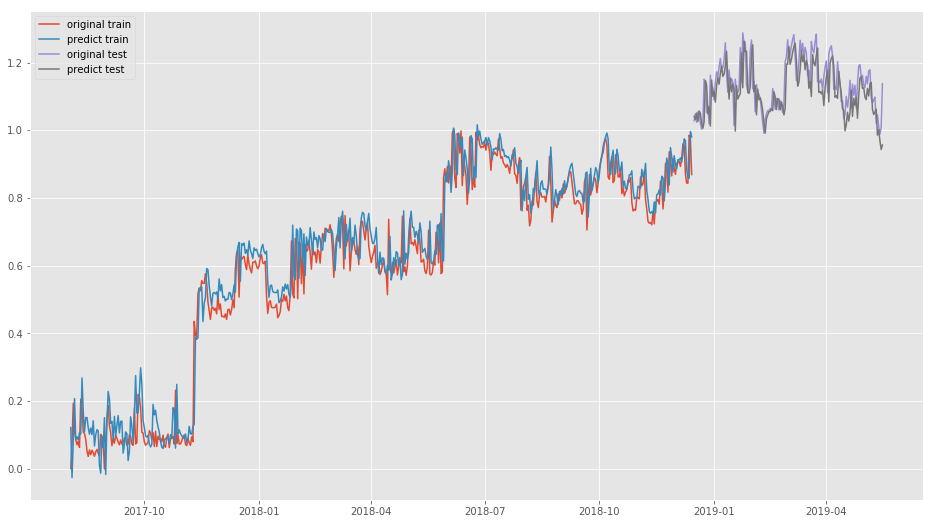

In [249]:
plt.figure(figsize=(16, 9))
plt.plot(w1['date'][1:500], y_tr3, label='original train')
plt.plot(w1['date'][1:500], y_t,   label='predict train')
plt.plot(w1['date'][501:], y_te3,  label='original test')
plt.plot(w1['date'][501:], y_pred, label='predict test')
plt.legend()
plt.show()

In [250]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_pred, y_te3), MAPE(y_pred, y_te3)))

MSE: 0.0035 | MAPE: 0.0735


In [233]:
m3.save('water-rate-loss-0.0035.hdf5')

In [242]:
# q_water = load_model('water-rate-loss-0.003.hdf5')
water = m3

y_t = water.predict(X_tr3)
y_pred = water.predict(X_te3)

y_hat = inverse(scaler, X_te3[:, :-1], y_pred)
y_train_hat = inverse(scaler, X_tr3[:, :-1], y_t)

In [244]:
predict_train_set = pd.DataFrame({'date': w1['date'][1:500].values,
                                  'orig': train3['q_water'][1:500].values,
                                  'pred': y_train_hat})

predict_test_set = pd.DataFrame({'date': w1['date'][501:].values,
                                 'orig': test3['q_water'][:-1].values,
                                 'pred': y_hat})

predict_train_set.to_csv('water_train.dat', index=False)
predict_test_set.to_csv('water_test.dat', index=False)

In [245]:
water.layers[2].get_weights()

[array([[-0.5690572 ],
        [-0.72561973],
        [ 0.25799325],
        [-0.62304187],
        [ 0.7223621 ],
        [ 0.10350298],
        [-0.26801243]], dtype=float32), array([0.02675278], dtype=float32)]

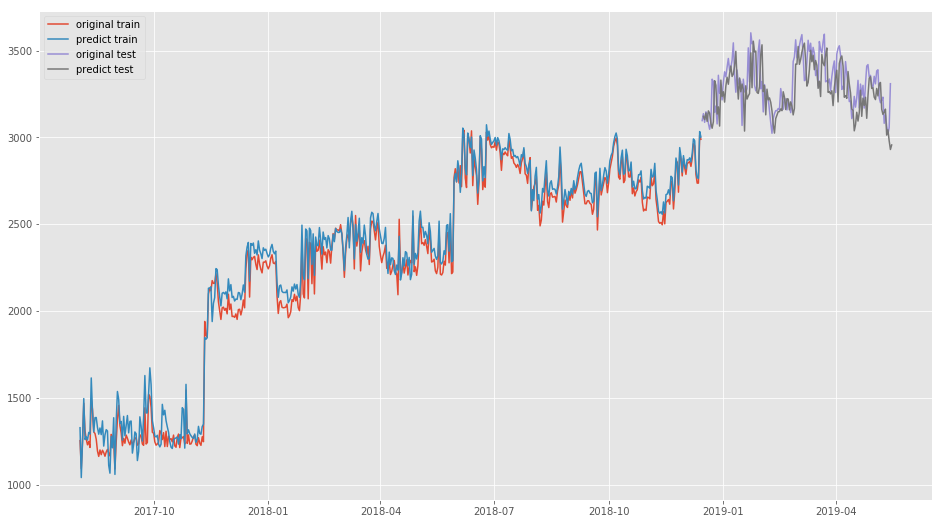

In [246]:
plt.figure(figsize=(16, 9))
plt.plot(w1['date'][1:500], train3['q_water'][:499], label='original train')
plt.plot(w1['date'][1:500], y_train_hat, label='predict train')
plt.plot(w1['date'][500:-1], test3['q_water'][1:], label='original test')
plt.plot(w1['date'][501:], y_hat, label='predict test')
plt.legend()
plt.show()

In [247]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(test3['q_water'][:-1], y_hat), MAPE(test3['q_water'][1:], y_hat)))

MSE: 2422.9736 | MAPE: 0.0275


## OIL RATE

In [251]:
train4 = pd.concat([train1.drop(['q_oil'], axis=1), train1['q_oil']], axis=1)
test4 = pd.concat([test1.drop(['q_oil'], axis=1), test1['q_oil']], axis=1)

In [252]:
scaler, train, test = scale(train4, test4)
cols = train4.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(500, 6) (153, 6)


In [253]:
vf_oil = test.values[-1].reshape((1, -1))
vf_oil

array([[ 0.12128599,  1.13748432,  0.39114137,  0.7093788 ,  0.879046  ,
        -0.28504901]])

In [254]:
X_tr4, y_tr4 = shift(train, 'q_oil', step=1)
X_te4, y_te4 = shift(test, 'q_oil', step=1)
print(X_tr4.shape, y_tr4.shape, X_te4.shape, y_te4.shape)

(499, 6) (499,) (152, 6) (152,)


In [265]:
m4 = Sequential()
m4.add(Dense(7, input_shape=(6, ), activation='linear'))
m4.add(LeakyReLU(alpha=0.001))
m4.add(Dense(1))
m4.compile(loss='mse', optimizer='adam')

In [266]:
epochs=60

h4 = m4.fit(X_tr4, y_tr4, 
          epochs=60,
          batch_size=6)

Epoch 1/60
499/499 [==============================] - 2s 4ms/step - loss: 0.3077
Epoch 2/60
499/499 [==============================] - 0s 465us/step - loss: 0.0517
Epoch 3/60
499/499 [==============================] - 0s 489us/step - loss: 0.0324
Epoch 4/60
499/499 [==============================] - 0s 497us/step - loss: 0.0285
Epoch 5/60
499/499 [==============================] - 0s 529us/step - loss: 0.0260
Epoch 6/60
499/499 [==============================] - ETA: 0s - loss: 0.023 - 0s 487us/step - loss: 0.0217
Epoch 7/60
499/499 [==============================] - 0s 523us/step - loss: 0.0178
Epoch 8/60
499/499 [==============================] - 0s 489us/step - loss: 0.0153
Epoch 9/60
499/499 [==============================] - 0s 499us/step - loss: 0.0130
Epoch 10/60
499/499 [==============================] - 0s 485us/step - loss: 0.0113
Epoch 11/60
499/499 [==============================] - 0s 523us/step - loss: 0.0098
Epoch 12/60
499/499 [==============================] - 0s 471us

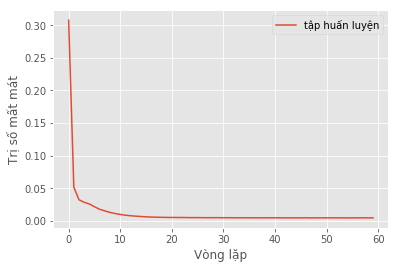

In [267]:
plt.plot(h4.history['loss'], label="tập huấn luyện")
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [268]:
loss = pd.DataFrame({'epochs': range(1, epochs+1),
                     'loss': h4.history['loss']})
loss.to_csv('w1-oil-loss.dat', index=False)

In [269]:
y_test_pred = m4.predict(X_te4)
y_train_pred = m4.predict(X_tr4)

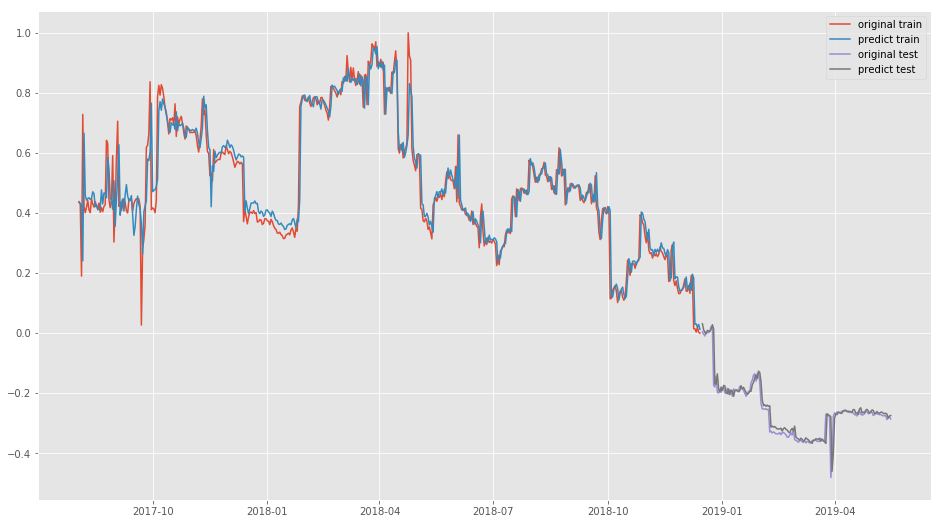

In [270]:
plt.figure(figsize=(16, 9))
plt.plot(w1['date'][1:500], y_tr4, label='original train')
plt.plot(w1['date'][1:500], y_train_pred, label='predict train')
plt.plot(w1['date'][501:], y_te4, label='original test')
plt.plot(w1['date'][501:], y_test_pred, label='predict test')
plt.legend()
plt.show()

In [271]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_test_pred, y_te4), MAPE(y_test_pred, y_te4)))

MSE: 0.0009 | MAPE: 3.7746


In [276]:
oil.save('oil-rate-loss-0.0009.hdf5')

In [272]:
# oil = load_model('oil-rate-loss-0.0009.hdf5')

oil = m4

y_train_pred = oil.predict(X_tr4)
y_test_pred = oil.predict(X_te4)

y_hat = inverse(scaler, X_te4[:, :-1], y_test_pred)
y_train_hat = inverse(scaler, X_tr4[:, :-1], y_train_pred)

In [273]:
predict_train_set = pd.DataFrame({'date': w1['date'][1:500].values,
                                  'orig': train4['q_oil'][1:500].values,
                                  'pred': y_train_hat})

predict_test_set = pd.DataFrame({'date': w1['date'][501:].values,
                                 'orig': test4['q_oil'][:-1].values,
                                 'pred': y_hat})

predict_train_set.to_csv('oil_train.dat', index=False)
predict_test_set.to_csv('oil_test.dat', index=False)

In [277]:
oil.layers[2].get_weights()

[array([[-0.6788846 ],
        [-0.63633066],
        [ 0.12945794],
        [ 0.33073324],
        [ 0.7166654 ],
        [ 0.6259443 ],
        [-0.7268088 ]], dtype=float32), array([0.1240219], dtype=float32)]

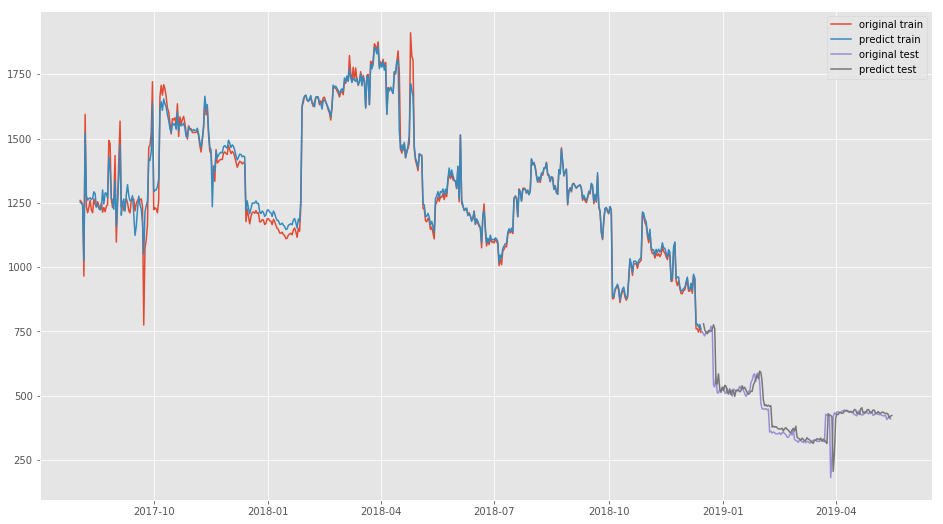

In [274]:
plt.figure(figsize=(16, 9))
plt.plot(w1['date'][1:500], train4['q_oil'][:499], label='original train')
plt.plot(w1['date'][1:500], y_train_hat, label='predict train')
plt.plot(w1['date'][500:-1], test4['q_oil'][1:], label='original test')
plt.plot(w1['date'][501:], y_hat, label='predict test')
plt.legend()
plt.show()

In [275]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(test4['q_oil'][:-1], y_hat), MAPE(test4['q_oil'][:-1], y_hat)))

MSE: 92.6195 | MAPE: 0.0187


## PREDICT

In [8]:
whft = load_model('whft-f-0.0038.hdf5')
pred = whft.predict(vf_whft)
whft_future = inverse(scaler, vf_whft[:, :-1], pred)

In [9]:
whft_future

array([83.19037235])

In [15]:
whfp = load_model('whfp-loss-0.0006.hdf5')
pred = whfp.predict(vf_whfp)
whfp_future = inverse(scaler, vf_whfp[:, :-1], pred)

In [16]:
whfp_future

array([278.70818072])

In [20]:
water = load_model('water-rate-loss-0.003.hdf5')
pred = water.predict(vf_water)
water_rate_future = inverse(scaler, vf_water[:, :-1], pred)

In [21]:
water_rate_future

array([3336.74498523])

In [71]:
oil = load_model('oil-rate-loss-0.0009.hdf5')
pred = oil.predict(vf_oil)
oil_rate_future = inverse(scaler, vf_oil[:, :-1], pred)

In [72]:
oil_rate_future

array([425.72354421])

In [312]:
t = whft.layers[2].get_weights()[0].reshape((1, -1))
p = whfp.layers[2].get_weights()[0].reshape((1, -1))
qw = water.layers[2].get_weights()[0].reshape((1, -1))
qo = oil.layers[2].get_weights()[0].reshape((1, -1))
weight = np.r_[qo, qw, t, p]
bias = np.r_[oil.layers[2].get_weights()[1], water.layers[2].get_weights()[1],\
             whft.layers[2].get_weights()[1], whfp.layers[2].get_weights()[1]].reshape((-1, 1))
q = np.c_[weight, bias]
x = pd.DataFrame(data=q, columns=['1', '2', '3', '4', '5', '6', '7', 'bias'])

In [315]:
x.to_csv('w1-weight.csv', index=False)